# Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias_A/bias1/bias2/bias3/bias4/bias5/"
#execute("./run_gromacs.sh",folder=folder)

Completed: ./run_gromacs.sh


In [4]:
data = load_dataframe(folder+"COLVAR")
olddata = load_dataframe("unbias_A/COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("../../../../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

## Adding the unbias data to the bias one
In order to use also the old data to obtain an estime on the fly of TICA cv we need to concat both data together  
The time of the bias data must be increase by the last valued of the old_data last time

In [5]:
data["time"] = data["time"] + olddata["time"].tail(1).values
data["opes.bias"] = data["opes.bias"]-min(data["opes.bias"])
newdata = pd.concat([ olddata,data],ignore_index=True).replace(np.nan, 0)

In [6]:
data = load_dataframe(folder+"COLVAR")

Text(0, 0.5, '$\\psi$')

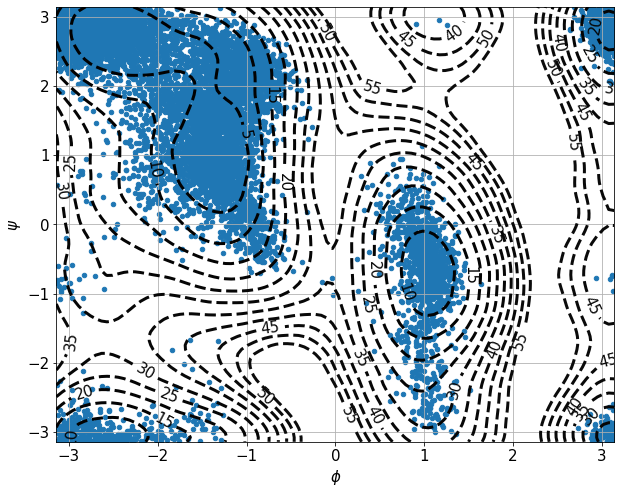

In [7]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
#load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)
data.plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../../../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

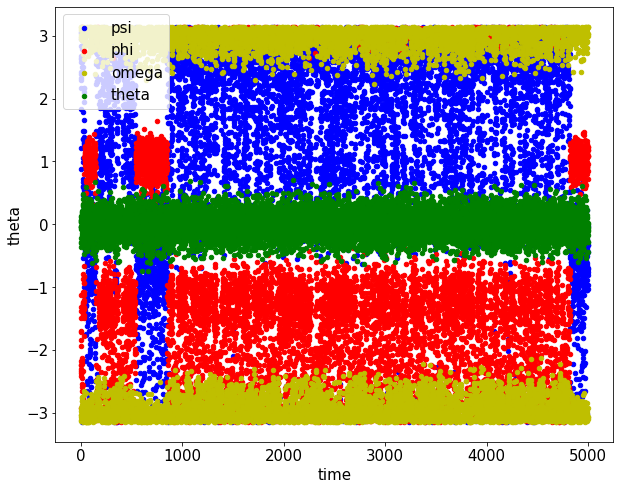

In [8]:
#data = load_dataframe(folder+"COLVAR")
fig,ax = plt.subplots(1,1,figsize=(10,8))
data.plot.scatter(x="time",y="psi",ax=ax, color="b", label="psi")
data.plot.scatter(x="time",y="phi",ax=ax, color="r", label="phi")
data.plot.scatter(x="time",y="omega",ax=ax, color="y", label="omega")
data.plot.scatter(x="time",y="theta",ax=ax, color="g", label="theta")
ax.legend()

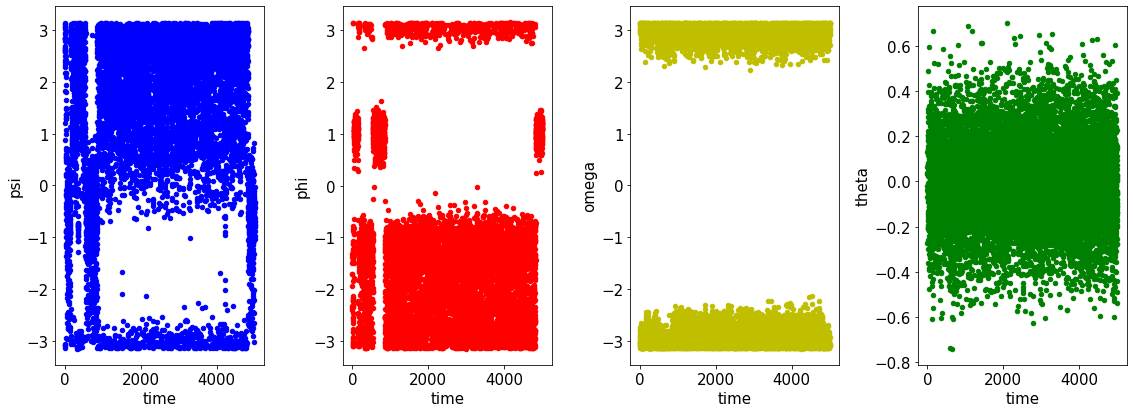

In [9]:
fig,axs = plt.subplots(1,4,figsize=(16,6))
data.plot.scatter(x="time",y="psi",ax=axs[0], color="b")
data.plot.scatter(x="time",y="phi",ax=axs[1], color="r")
data.plot.scatter(x="time",y="omega",ax=axs[2], color="y")
data.plot.scatter(x="time",y="theta",ax=axs[3], color="g")
plt.tight_layout()

<AxesSubplot:xlabel='psi', ylabel='omega'>

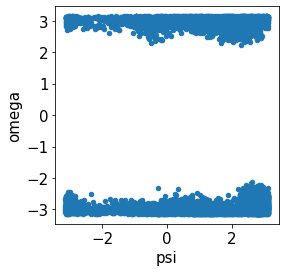

In [10]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
#load_dataframe(folder+"COLVAR").plot.scatter(y="omega",x="psi",ax=ax)
data.plot.scatter(y="omega",x="psi",ax=ax)

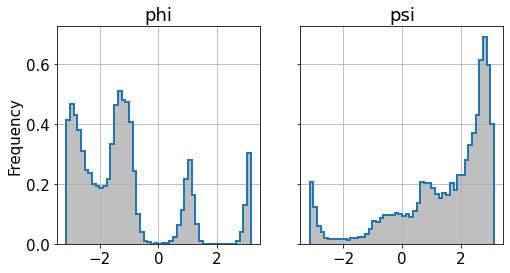

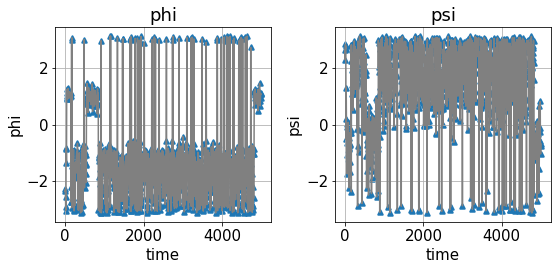

In [11]:
#data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(8,4))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

In [12]:
#gridspec_fes(s,logweight,sim_parameters)

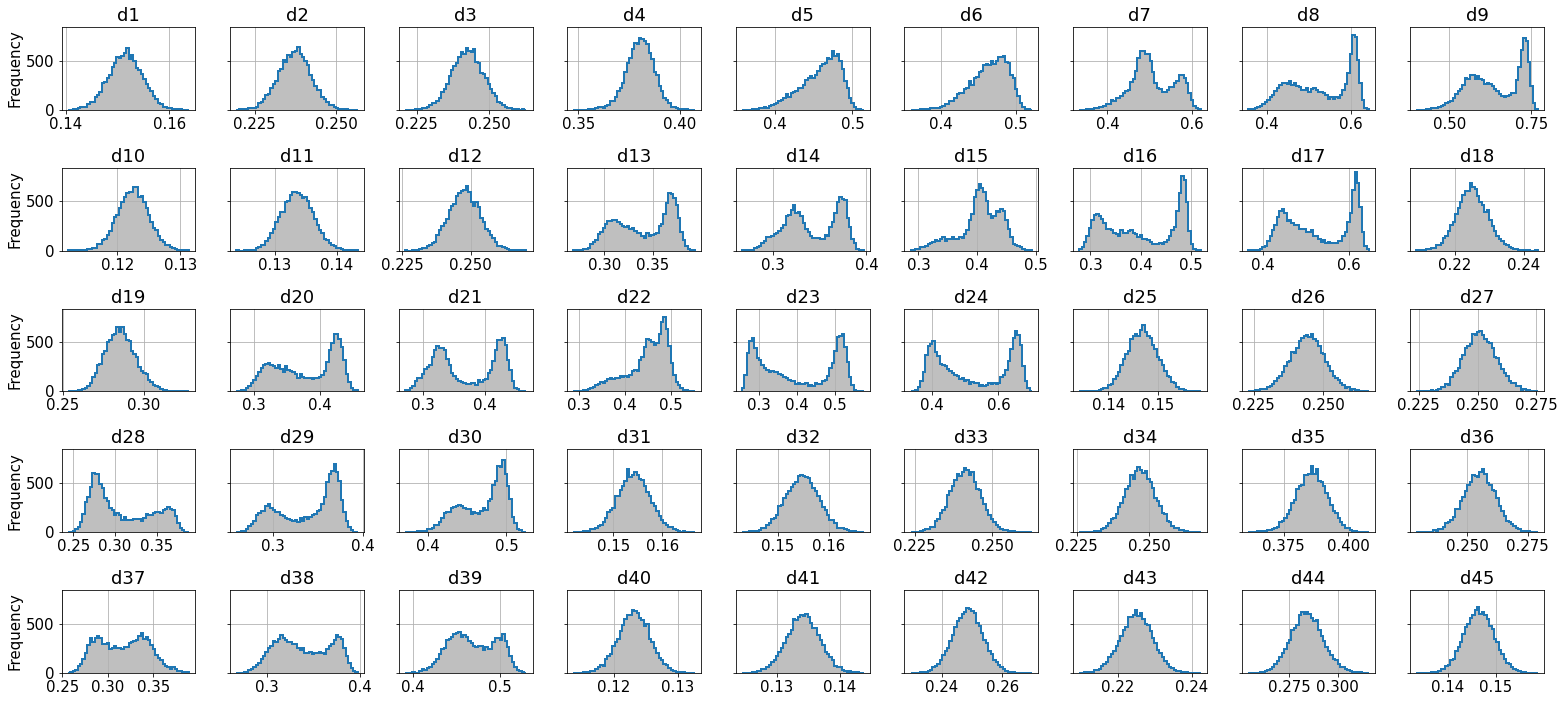

In [13]:
#data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values

fig,axs = plt.subplots(5,9,figsize=(22,10),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2)#,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey")#,density=True)
    ax.set_title(desc)

plt.tight_layout()

In [14]:
#-- TRAINING PARAMETERS --#
train_parameters = {
              'descriptors': '^d[^a-z]',
              'lag_time':10,
              'standardize_outputs':True,
              'standardize_inputs': True,
              #if reweight the timescale
              "reweighting": True,
              "step": 1 #se prendo tutti i valori fallisce il cholesky decomposition.. issue con pytorch
              }
#--------------------------------------#

In [15]:
'''
data = load_dataframe(folder+"COLVAR")
data = data[::train_parameters["step"]]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values
logweights = data["opes.bias"].to_numpy()*sim_parameters["beta"]
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

lags = np.linspace(1,10,10)
timescale = np.empty(len(lags))

for i,lag in enumerate(lags):
    # TRAIN
    model.fit(X, t, lag=lag, logweights=logweights)
    #-- move the model back to cpu for convenience --# 
    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
model.to('cpu')
'''

'\ndata = load_dataframe(folder+"COLVAR")\ndata = data[::train_parameters["step"]]\nX, names, t = data.filter(regex=\'^d[^a-z]\').values, data.filter(regex=\'^d[^a-z]\').columns.values, data[\'time\'].values\nlogweights = data["opes.bias"].to_numpy()*sim_parameters["beta"]\n# DEVICE\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# MODEL\nmodel = TICA_CV(n_features=X.shape[1])\nmodel.to(device)\n\nlags = np.linspace(1,10,10)\ntimescale = np.empty(len(lags))\n\nfor i,lag in enumerate(lags):\n    # TRAIN\n    model.fit(X, t, lag=lag, logweights=logweights)\n    #-- move the model back to cpu for convenience --# \n    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]\nmodel.to(\'cpu\')\n'

In [16]:
#plt.plot(lags,timescale)
#print(timescale)
#print(lags)

## DeepTICA Analysis and Export

In [17]:
torch.manual_seed(21)

#data
data = load_dataframe(folder+"COLVAR")
data = data[:]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values
logweights = data["opes.bias"].to_numpy()*sim_parameters["beta"]

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

#tprime
dt = np.round(t[1]-t[0],3)
sum = torch.exp(torch.Tensor(logweights))
tprime = dt * torch.exp ( torch.log (torch.cumsum ( sum ,0 ) ) )

# TRAIN
model.fit(X, t, lag=1,logweights=logweights)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
#print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

model.set_params({"feature_names": names})
print( model.plumed_input().splitlines()[:2] )

RuntimeError: CUDA error: out of memory

In [ ]:
X = data.filter(regex=train_parameters["descriptors"]).values
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data["cv3"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[2]
data["cv4"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[3]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]
data_complete["cv3"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[2]
data_complete["cv4"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[3]

In [ ]:
fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b",label="cv1 data")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b",label="cv2 data")
data.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="b",label="cv3 data")
data.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="b",label="cv4 data")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,histtype='step',color="r",linewidth=2,label="cv1 data complete")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,histtype='step',color="r",linewidth=2,label="cv2 data complete")
data_complete.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,histtype='step',color="r",linewidth=2,label="cv3 data complete")
data_complete.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,histtype='step',color="r",linewidth=2,label="cv4 data complete")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

In [ ]:
fig,axs = plt.subplots(4,1,figsize=(16,24),sharex=True)
for k,cv in enumerate(["cv1","cv2","cv3","cv4"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(tica|desc)$")
    axs[k].set_title('Correlation with TICA '+str(k+1))
plt.show()

In [ ]:
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()

In [ ]:
names = ["psi","phi","omega","theta"]
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

fig,axs = plt.subplots(1,2,figsize=(16,4))
for i,ax in enumerate(axs):
    data_complete.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(16,4))
for i,ax in enumerate(axs):
    data_complete.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

### FES estimate from new cvs   

In [ ]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()

fig, ax = plt.subplots(figsize=(6,6))
for i in range(4):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweights),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate","F(cv3) estimate","F(cv4) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cvs)$")
ax.set_ylabel("FES [Kj/mol]")

plt.show()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [ ]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweights)